# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import tensorflow as tf

from helpers import parse_variables, get_risk_level, map_to_color, simulate_quant_trait
from models import ols_regression, manhattan_linear, gc
from deep_learning_models import abyss, deep_abyss

import warnings
from scipy.stats import t
from scipy import stats
from scipy.stats import entropy

warnings.filterwarnings("ignore")

2024-07-04 19:24:01.531325: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-04 19:24:01.535157: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-04 19:24:01.547226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 19:24:01.570885: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 19:24:01.570921: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-04 19:24:01.586615: I tensorflow/core/platform/cpu_feature_guard.cc:

In [2]:
naming_dict = {
    "no_risk": "no environmental risk",
    "NW_risk": "Smooth linear North-West environmental risk",
    "N_risk" : "Smooth linear North environmental risk",
    "blob_risk": "Localised big blob risk",
    "center_risk": "Localised big central risk",
    "big_square_risk": "big square risk",
    "square_risk" : "Tiny square risk",
    'hi_square_risk' : "Tiny square risk",
    "hi_gauss_blob_risk": "Global Gaussian Risk",
    "two_square_risk": "Two tiny risks",
    "gauss_blob_risk" : "Gaussian Risk"
}

# Load genotype

In [3]:
dict = parse_variables('geno_simulation.txt')
G = int(dict['G'])
L = int(dict['L'])
c = int(dict['c'])
k = int(dict['k'])
M = float(dict['M'])

# Thresholds
very_rare_threshold_L = float(dict['very_rare_threshold_L'])
very_rare_threshold_H = float(dict['very_rare_threshold_H'])

rare_threshold_L = float(dict['rare_threshold_L'])
rare_threshold_H = float(dict['rare_threshold_H'])

common_threshold_L = float(dict['common_threshold_L'])
common_threshold_H = float(dict['common_threshold_H'])

number_of_snps = (G*L)/2 # one loci per chromosome
number_of_individuals = c*k*k

In [4]:
very_rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_rare_genotype_AF_{rare_threshold_L}_{rare_threshold_H}.pkl")
common = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")

In [5]:
very_rare = very_rare.rename(columns=lambda x: 'VR' + x)/2
rare = rare.rename(columns=lambda x: 'R' + x)/2
common = common.rename(columns=lambda x: 'C' + x)/2
complete = pd.concat([common, rare, very_rare], axis=1)
complete = ((complete*2)-1)

# Load populations

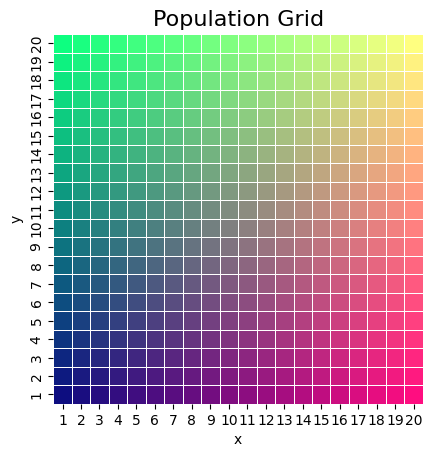

In [6]:
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/01_population_structure.pkl")
populations['population_number'] = populations['populations'].str.extract('(\d+)').astype(int)
# Calculating X and Y coordinates
populations['x'] = ((populations['population_number'] - 1) % k) + 1
populations['y'] = ((populations['population_number'] - 1) // k) + 1
populations['z'] = 0.5
populations['population'] = populations['population_number']/(k*k)
palette = [map_to_color(x, y, z, populations) for x, y, z in zip(populations['x'], populations['y'], populations['z'])]

# Check the grid
df_agg = populations.groupby(['x', 'y']).agg({'population': 'mean'}).reset_index()

# Now, pivot the aggregated DataFrame
grid_df = df_agg.pivot(index='y', columns='x', values='population')


heatmap = sns.heatmap(grid_df, cmap=palette, linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title('Population Grid', fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()



# Load environmental risk

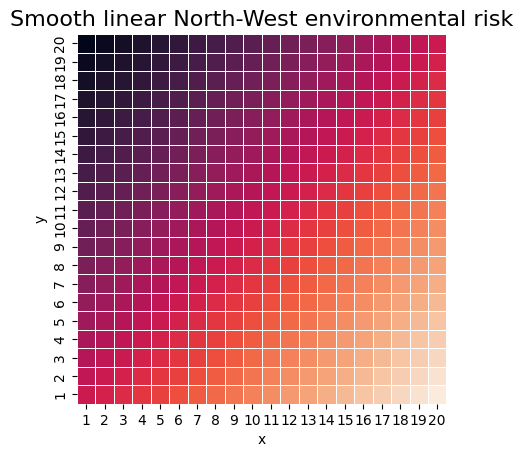

In [7]:
risk_level = get_risk_level()
risk_level = risk_level.split("\n")[-1]
name_risk = risk_level.split('_fun')[0]
risk = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/environmental_risks/risk_{name_risk}.pkl")
populations[name_risk] = risk[name_risk]
df_agg = populations.groupby(['x', 'y']).agg({name_risk: 'mean'}).reset_index()
grid_df = df_agg.pivot(index='y', columns='x', values=name_risk)
sns.heatmap(grid_df, cmap='rocket_r', linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title(f"{naming_dict[name_risk]}", fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()

# Find true MAF per populations

In [10]:
complete['pop'] = populations['population_number']

In [23]:
for snp in list(complete.columns)[0:-1][0:1]:
    temp = complete[[snp,'pop']]
    for pop in list(populations['population_number'].unique()):
        temp2 = temp[[snp,'pop']]
        temp2 = temp2[temp2['pop']==pop]

In [24]:
temp2

snps,C0_AF_0.296425,pop
19950,1.0,400
19951,1.0,400
19952,1.0,400
19953,1.0,400
19954,1.0,400
19955,1.0,400
19956,1.0,400
19957,1.0,400
19958,1.0,400
19959,1.0,400


In [32]:
temp2[snp]-1

19950    0.0
19951    0.0
19952    0.0
19953    0.0
19954    0.0
19955    0.0
19956    0.0
19957    0.0
19958    0.0
19959    0.0
19960    0.0
19961    0.0
19962    0.0
19963    0.0
19964    0.0
19965    0.0
19966    0.0
19967    0.0
19968    0.0
19969    0.0
19970    0.0
19971    0.0
19972    0.0
19973    0.0
19974    0.0
19975    0.0
19976    0.0
19977    0.0
19978    0.0
19979    0.0
19980    0.0
19981    0.0
19982    0.0
19983    0.0
19984    0.0
19985    0.0
19986    0.0
19987    0.0
19988    0.0
19989    0.0
19990    0.0
19991    0.0
19992    0.0
19993    0.0
19994    0.0
19995    0.0
19996    0.0
19997    0.0
19998    0.0
19999    0.0
Name: C0_AF_0.296425, dtype: float64

In [36]:
test = temp2[snp]-2
# Count the occurrences of each allele
allele_counts = test.value_counts()

# Calculate the total number of alleles (assuming each individual has 2 alleles)
total_alleles = 2 * len(temp2)


# Ensure all possible alleles are considered (-1.0, 0.0, 1.0)
for allele in [-1.0, 0.0, 1.0]:
    if allele not in allele_counts:
        allele_counts[allele] = 0

# Calculate the frequency of each allele
allele_frequencies = allele_counts / total_alleles

# Identify the minor allele frequency (the minimum of the allele frequencies excluding zero counts)
if allele_frequencies.min() == 0 and (allele_frequencies > 0).sum() == 1:
    maf = 0
else:
    maf = allele_frequencies[allele_frequencies > 0].min()

In [38]:
test

19950   -1.0
19951   -1.0
19952   -1.0
19953   -1.0
19954   -1.0
19955   -1.0
19956   -1.0
19957   -1.0
19958   -1.0
19959   -1.0
19960   -1.0
19961   -1.0
19962   -1.0
19963   -1.0
19964   -1.0
19965   -1.0
19966   -1.0
19967   -1.0
19968   -1.0
19969   -1.0
19970   -1.0
19971   -1.0
19972   -1.0
19973   -1.0
19974   -1.0
19975   -1.0
19976   -1.0
19977   -1.0
19978   -1.0
19979   -1.0
19980   -1.0
19981   -1.0
19982   -1.0
19983   -1.0
19984   -1.0
19985   -1.0
19986   -1.0
19987   -1.0
19988   -1.0
19989   -1.0
19990   -1.0
19991   -1.0
19992   -1.0
19993   -1.0
19994   -1.0
19995   -1.0
19996   -1.0
19997   -1.0
19998   -1.0
19999   -1.0
Name: C0_AF_0.296425, dtype: float64

In [27]:
allele_counts

C0_AF_0.296425
1.0    50
Name: count, dtype: int64